In [1]:
import os
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import SeparableConv2D
from keras.layers import MaxPooling2D
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Dense
from keras.models import load_model

import cv2
import numpy as np
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [27]:
# define the initial learning rate, batch size, and number of epochs
INIT_LR = 0.1
BATCH_SIZE = 64
NUM_EPOCHS = 50
lr_find = True

classes = ['Non_Fire','Fire']

In [3]:
images = []
labels = []
for c in classes:
    try:
        for img in os.listdir('Image Dataset/'+c):
            img = cv2.imread('Image Dataset/'+c+'/'+img)
            img = cv2.resize(img,(128,128))
            images.append(img)
            labels.append([0,1][c=='Fire'])
    except:
        pass
    
images = np.array(images,dtype='float32')/255.


In [4]:
# just visualizing random images from the dataset created above 

ind = np.random.randint(0,len(images))
cv2.imshow(str(labels[ind]),images[ind])
cv2.waitKey(0)
cv2.destroyAllWindows()

In [5]:
labels = np.array(labels)
labels = np_utils.to_categorical(labels,num_classes=2)

classTotals = labels.sum(axis=0)
classWeight = classTotals.max() / classTotals

In [6]:
classTotals

array([2688., 1315.], dtype=float32)

In [7]:
classWeight

array([1.       , 2.0441065], dtype=float32)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.25, shuffle=True, random_state=42)

In [9]:
aug = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [10]:
model = Sequential()

# CONV => RELU => POOL
model.add(SeparableConv2D(32,(3,3),padding='same',input_shape=(128,128,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# CONV => RELU => CONV => RELU => POOL
model.add(SeparableConv2D(64,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(SeparableConv2D(64,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# first set of FC => RELU layers
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))


# second set of FC => RELU layers
model.add(Dense(128))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# softmax classifier
model.add(Dense(len(classes)))
model.add(Activation("softmax"))

opt = SGD(learning_rate=INIT_LR, momentum=0.9,decay=INIT_LR / NUM_EPOCHS)

model.compile(loss=['binary_crossentropy'],
              optimizer=opt,
              metrics=['accuracy'])

print(model.summary())

W0331 17:19:16.239598 18472 deprecation_wrapper.py:119] From C:\Users\sharma ji\AppData\Roaming\Python\Python37\site-packages\keras\backend\tensorflow_backend.py:4070: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_1 (Separabl (None, 128, 128, 32)      155       
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
separable_conv2d_2 (Separabl (None, 64, 64, 64)        2400      
_________________________________________________________________
activation_2 (Activation)    (None, 64, 64, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 64)       

In [ ]:
from pyimagesearch.learningratefinder import LearningRateFinder 
# if "lr_find" ==True:
    # initialize the learning rate finder and then train with learning
    # rates ranging from 1e-10 to 1e+1
print("[INFO] finding learning rate...")
lrf = LearningRateFinder(model)
# start from 1e-10 till 1e+1
lrf.find(
    aug.flow(X_train, y_train, batch_size=BATCH_SIZE),
    1e-10, 1e+1,
    stepsPerEpoch=np.ceil((X_train.shape[0] / float(BATCH_SIZE))),
    epochs=20,
    batchSize=BATCH_SIZE,
    classWeight=classWeight)
# plot the loss for the various learning rates and save the
# resulting plot to disk
lrf.plot_loss()
plt.savefig("output/lrfind_plot.png")
# gracefully exit the script so we can adjust our learning rates
# in the config and then train the network for our full set of
# epochs
print("[INFO] learning rate finder complete")
print("[INFO] examine plot and adjust learning rates before training")

In [11]:
print("[INFO] training network...")

H = model.fit_generator(
    aug.flow(X_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(X_test, y_test),
    steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
    epochs=NUM_EPOCHS,
    class_weight=classWeight,
    verbose=1)

print("[INFO] serializing network to '{}'...".format('output/model'))
model.save('output/fire_detection.h5')

W0331 17:19:25.735089 18472 deprecation.py:323] From C:\Users\sharma ji\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


[INFO] training network...


W0331 17:19:27.267061 18472 deprecation_wrapper.py:119] From C:\Users\sharma ji\AppData\Roaming\Python\Python37\site-packages\keras\backend\tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Epoch 1/50
46/46 [==============================] - 247s 5s/step - loss: 1.0360 - accuracy: 0.6508 - val_loss: 5.3933 - val_accuracy: 0.6474
Epoch 2/50
46/46 [==============================] - 256s 6s/step - loss: 0.6056 - accuracy: 0.7243 - val_loss: 4.3200 - val_accuracy: 0.6993
Epoch 3/50
46/46 [==============================] - 259s 6s/step - loss: 0.4957 - accuracy: 0.7403 - val_loss: 2.2504 - val_accuracy: 0.7333
Epoch 4/50
46/46 [==============================] - 267s 6s/step - loss: 0.4963 - accuracy: 0.7556 - val_loss: 1.1817 - val_accuracy: 0.7323
Epoch 5/50
46/46 [==============================] - 272s 6s/step - loss: 0.4790 - accuracy: 0.7768 - val_loss: 0.6147 - val_accuracy: 0.7483
Epoch 6/50
46/46 [==============================] - 267s 6s/step - loss: 0.4620 - accuracy: 0.7713 - val_loss: 0.4106 - val_accuracy: 0.7982
Epoch 7/50
46/46 [==============================] - 240s 5s/step - loss: 0.4373 - accuracy: 0.7797 - val_loss: 0.8306 - val_accuracy: 0.7393
Epoch 8/50
46

OSError: Unable to create file (unable to open file: name = 'output/model', errno = 13, error message = 'Permission denied', flags = 13, o_flags = 302)

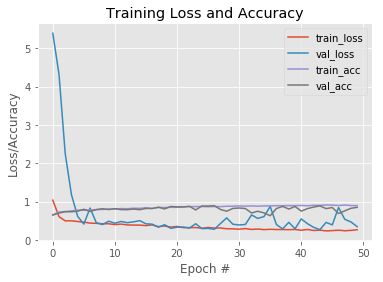

In [30]:
N = np.arange(0, NUM_EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")
plt.savefig("output/training_plot.png")

In [16]:
# load the trained model from disk
print("[INFO] loading model...")
model = load_model('output/fire_detection.h5')

[INFO] loading model...


In [29]:
for i in range(50):
    random_index = np.random.randint(0,len(images))
    org_img = images[random_index]*255
    img = org_img.copy()
    img = cv2.resize(img,(128,128))
    img = img.astype('float32')/256
    pred = model.predict(np.expand_dims(img,axis=0))[0]
    result = classes[np.argmax(pred)]
    org_img = cv2.resize(org_img,(500,500))
    cv2.putText(org_img, result, (35, 50), cv2.FONT_HERSHEY_SIMPLEX,1.25, (0, 255, 0), 5)
    cv2.imwrite('output/testing/{}.png'.format(i),org_img)